<a href="https://colab.research.google.com/github/sunflowerseed17/PythonDSProject/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Loading

In [12]:
import glob
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from empath import Empath
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from statsmodels.stats.multitest import multipletests


import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Base Class
class FeatureExtractor:
    def __init__(self, documents, labels, output_folder="data/feature_extracted_data"):
        self.documents = documents
        self.labels = labels
        self.output_folder = output_folder
        os.makedirs(self.output_folder, exist_ok=True)

    def preprocess_text(self, text):
        """
        Tokenize, lowercase, remove stopwords, and stem.
        """
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        tokens = word_tokenize(text.lower())
        return [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]

    def save_to_csv(self, data, filename):
        """
        Save data to a CSV file.
        """
        file_path = os.path.join(self.output_folder, filename)
        if not os.path.exists(file_path):
            data.to_csv(file_path, index=False)
            print(f"Saved to {file_path}.")
        else:
            print(f"File already exists at {file_path}.")

# N-Gram Feature Extractor
class NGramFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, output_folder="data/feature_extracted_data"):
        super().__init__(documents, labels, output_folder)
        self.vectorizer_unigram = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
        self.vectorizer_bigram = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
        self.vectorizer_combined = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') 
        self.unigram_matrix = None
        self.bigram_matrix = None
        self.unigram_feature_names = None
        self.bigram_feature_names = None
        self.combined_matrix = None
        self.combined_feature_names = None

        os.makedirs(self.output_folder, exist_ok=True)

    def extract_features(self):
        """
        Extract unigram and bigram features using TF-IDF.
        """
        print("Extracting unigrams...")
        self.unigram_matrix = self.vectorizer_unigram.fit_transform(self.documents)
        self.unigram_feature_names = self.vectorizer_unigram.get_feature_names_out()
        print(f"Number of unigram features: {len(self.unigram_feature_names)}")

        print("Extracting bigrams...")
        self.bigram_matrix = self.vectorizer_bigram.fit_transform(self.documents)
        self.bigram_feature_names = self.vectorizer_bigram.get_feature_names_out()
        print(f"Number of bigram features: {len(self.bigram_feature_names)}")

        print("Extracting combined unigrams and bigrams...")
        self.combined_matrix = self.vectorizer_combined.fit_transform(self.documents)
        self.combined_feature_names = self.vectorizer_combined.get_feature_names_out()
        print(f"Number of combined unigram and bigram features: {len(self.combined_feature_names)}")

        return self.unigram_matrix, self.bigram_matrix, self.combined_matrix
    
    def save_features(self):
        """
        Save unigram and bigram features with labels as CSV files.
        """
        unigram_file = os.path.join(self.output_folder, "unigram_features_with_labels.csv")
        bigram_file = os.path.join(self.output_folder, "bigram_features_with_labels.csv")

        if not os.path.exists(unigram_file):
            unigram_df = pd.DataFrame(self.unigram_matrix.toarray(), columns=self.unigram_feature_names)
            unigram_df['label'] = self.labels
            unigram_df.to_csv(unigram_file, index=False)
            print(f"Saved unigram features to {unigram_file}.")
        else:
            print(f"Unigram features file already exists at {unigram_file}.")

        if not os.path.exists(bigram_file):
            bigram_df = pd.DataFrame(self.bigram_matrix.toarray(), columns=self.bigram_feature_names)
            bigram_df['label'] = self.labels
            bigram_df.to_csv(bigram_file, index=False)
            print(f"Saved bigram features to {bigram_file}.")
        else:
            print(f"Bigram features file already exists at {bigram_file}.")

    def get_top_features(self, feature_type="unigram", top_n=10):
        """
        Get the top N most common features for unigrams or bigrams based on TF-IDF scores.
        """
        if feature_type == "unigram":
            tfidf_sums = np.array(self.unigram_matrix.sum(axis=0)).flatten()
            feature_names = self.unigram_feature_names
        elif feature_type == "bigram":
            tfidf_sums = np.array(self.bigram_matrix.sum(axis=0)).flatten()
            feature_names = self.bigram_feature_names
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        top_indices = np.argsort(tfidf_sums)[-top_n:]
        print(f"Top {top_n} Most Common {feature_type.capitalize()} Features:")
        for i in reversed(top_indices):
            print(f"{feature_names[i]}: {tfidf_sums[i]:.4f}")

    def train_model(self, feature_type="unigram"):
        """
        Train a Logistic Regression model using unigrams or bigrams.
        """
        if feature_type == "unigram":
            X = self.unigram_matrix
        elif feature_type == "bigram":
            X = self.bigram_matrix
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram' or 'bigram'.")

        X_train, X_test, y_train, y_test = train_test_split(X, self.labels, test_size=0.2, random_state=42)
        print(f"Training set size: {X_train.shape}")
        print(f"Testing set size: {X_test.shape}")

        param_grid = {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }
        grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        print("\nBest Hyperparameters:")
        print(grid_search.best_params_)

        classifier = grid_search.best_estimator_
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

        return classifier

    def visualize_wordcloud(self, feature_type="unigram", max_words=100, title="Word Cloud"):
        """
        Generate a word cloud for unigrams or bigrams or combined with a specific label.
        """
            # Select the appropriate matrix and feature names
        if feature_type == "unigram":
            matrix = self.unigram_matrix
            feature_names = self.unigram_feature_names
            title = "Unigram Word Cloud"
        elif feature_type == "bigram":
            matrix = self.bigram_matrix
            feature_names = self.bigram_feature_names
            title = "Bigram Word Cloud"
        elif feature_type == "combined":
            if not hasattr(self, "combined_matrix") or not hasattr(self, "combined_feature_names"):
                raise ValueError("Combined features must be extracted before generating a word cloud.")
            matrix = self.combined_matrix
            feature_names = self.combined_feature_names
            title = "Combined Unigram and Bigram Word Cloud"
        else:
            raise ValueError("Invalid feature_type. Choose 'unigram', 'bigram', or 'combined'.")

        # Sum TF-IDF scores across all documents
        tfidf_sums = np.array(matrix.sum(axis=0)).flatten()

        # Create a dictionary mapping feature names to their TF-IDF scores
        word_scores = {feature_names[i]: tfidf_sums[i] for i in range(len(feature_names))}
    
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words)
        wordcloud = wordcloud.generate_from_frequencies(word_scores)
    
        # Display the word cloud
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=16)
        plt.show()


# Empath Feature Extractor
class EmpathFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, selected_categories, output_folder="data/feature_extracted_data"):
        """
        Initialize the EmpathFeatureExtractor class.

        Parameters:
        documents (list of str): List of documents to analyze.
        labels (list of int): Labels corresponding to the documents.
        selected_categories (dict): Categories for Empath analysis.
        output_folder (str): Folder to save the results.
        """
        super().__init__(documents, labels, output_folder)
        self.lexicon = Empath()
        self.categories = selected_categories
        self.features = None
        self.correlation_results = None
        self.significant_results = None

    def extract_empath_features(self):
        """
        Extract Empath features based on the selected categories.
        """
        features = []
        for doc in self.documents:
            doc_features = {}

            # Linguistic features
            for category in self.categories["linguistic_features"]:
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Psychological processes
            for subcategory, categories in self.categories["psychological_processes"].items():
                for category in categories:
                    doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Personal concerns
            for category in self.categories["personal_concerns"]:
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            # Time orientations
            for category in self.categories["time_orientations"]:
                doc_features[category] = self.lexicon.analyze(doc, categories=[category])[category]

            features.append(doc_features)

        # Convert to a DataFrame
        self.features = pd.DataFrame(features)
        print(f"Extracted Empath features with shape: {self.features.shape}")

    def analyze_correlation(self):
        """
        Analyze correlations between extracted features and labels.
        """
        if self.features is None:
            raise ValueError("Features must be extracted before analyzing correlations.")

        # Remove constant columns
        constant_columns = self.features.columns[self.features.nunique() == 1]
        self.features = self.features.drop(columns=constant_columns)
        print(f"Removed constant columns: {constant_columns.tolist()}")

        # Validate labels
        if len(set(self.labels)) == 1:
            raise ValueError("Labels array is constant; cannot compute correlation.")

        correlations, p_values = [], []

        for column in self.features.columns:
            try:
                # Calculate Pearson correlation and p-value
                correlation, p_value = pearsonr(self.features[column], self.labels)
                correlations.append(correlation)
                p_values.append(p_value)
            except ValueError as e:
                print(f"Skipping feature {column} due to constant input.")
                correlations.append(None)
                p_values.append(None)

        # Apply Benjamini-Hochberg correction
        correction_results = multipletests(p_values, alpha=0.05, method="fdr_bh")
        _, corrected_p_values, _, _ = correction_results

        # Create correlation results DataFrame
        self.correlation_results = pd.DataFrame({
            "Feature": self.features.columns,
            "Correlation": correlations,
            "P-Value": p_values,
            "Corrected P-Value": corrected_p_values
        }).sort_values(by="Correlation", key=abs, ascending=False)

    def filter_significant_results(self):
        """
        Filter significant results based on corrected P-values.
        """
        if self.correlation_results is None:
            raise ValueError("Correlation analysis must be performed before filtering significant results.")

        def significance_stars(p):
            if p < 0.001:
                return '***'
            elif p < 0.01:
                return '**'
            elif p < 0.05:
                return '*'
            return ''  # No significance

        self.correlation_results["Significance"] = self.correlation_results["Corrected P-Value"].apply(significance_stars)
        self.significant_results = self.correlation_results[self.correlation_results["Significance"] != '']

    def map_features_to_categories(self):
        """
        Map significant features to their respective categories.
        """
        if self.significant_results is None:
            raise ValueError("Significant results must be filtered before mapping features to categories.")

        def map_features(features, categories):
            grouped_results = {}
            for feature in features:
                for category, subcategories in categories.items():
                    if isinstance(subcategories, list):  # Flat category
                        if feature in subcategories:
                            grouped_results.setdefault(category, []).append(feature)
                    elif isinstance(subcategories, dict):  # Nested subcategories
                        for subcategory, sub_features in subcategories.items():
                            if feature in sub_features:
                                grouped_results.setdefault(f"{category} - {subcategory}", []).append(feature)
            return grouped_results

        grouped_results = map_features(self.significant_results["Feature"], self.categories)
        print("Mapped features to categories.")

        formatted_results = [
            {
                "Category": category,
                "Feature": feature,
                "Correlation": self.significant_results.loc[self.significant_results["Feature"] == feature, "Correlation"].values[0],
                "P-Value": self.significant_results.loc[self.significant_results["Feature"] == feature, "P-Value"].values[0],
                "Significance": self.significant_results.loc[self.significant_results["Feature"] == feature, "Significance"].values[0],
            }
            for category, features in grouped_results.items()
            for feature in features
        ]
        return pd.DataFrame(formatted_results).sort_values(by=["Category", "Correlation"], ascending=[True, False])

    def save_features_and_results(self):
        """
        Save extracted features and correlation results to CSV files.
        """
        if self.features is not None:
            feature_file = os.path.join(self.output_folder, "empath_features_with_labels.csv")
            self.features["label"] = self.labels
            self.save_to_csv(self.features, feature_file)

        if self.correlation_results is not None:
            correlation_file = os.path.join(self.output_folder, "empath_correlation_results.csv")
            self.save_to_csv(self.correlation_results, correlation_file)


    def analyze_correlation(self):
        """
        Analyze correlations between extracted features and labels.
        """
        if self.features is None:
            raise ValueError("Features must be extracted before analyzing correlations.")

        # Remove constant columns
        constant_columns = self.features.columns[self.features.nunique() == 1]
        self.features = self.features.drop(columns=constant_columns)
        print(f"Removed constant columns: {constant_columns.tolist()}")

        # Validate labels
        if len(set(self.labels)) == 1:
            raise ValueError("Labels array is constant; cannot compute correlation.")

        correlations, p_values = [], []

        for column in self.features.columns:
            try:
                # Calculate Pearson correlation and p-value
                correlation, p_value = pearsonr(self.features[column], self.labels)
                correlations.append(correlation)
                p_values.append(p_value)
            except ValueError as e:
                print(f"Skipping feature {column} due to constant input.")
                correlations.append(None)
                p_values.append(None)

        # Apply Benjamini-Hochberg correction
        correction_results = multipletests(p_values, alpha=0.05, method="fdr_bh")
        _, corrected_p_values, _, _ = correction_results

        # Create correlation results DataFrame
        self.correlation_results = pd.DataFrame({
            "Feature": self.features.columns,
            "Correlation": correlations,
            "P-Value": p_values,
            "Corrected P-Value": corrected_p_values
        }).sort_values(by="Correlation", key=abs, ascending=False)

# LDA Feature Extractor
class LDAFeatureExtractor(FeatureExtractor):
    def __init__(self, documents, labels, num_topics=10, passes=10):
        super().__init__(documents, labels)
        self.num_topics = num_topics
        self.passes = passes

    def preprocess_documents(self):
        """
        Preprocess documents for LDA.
        """
        return [self.preprocess_text(doc) for doc in self.documents]

    def train_lda(self, processed_docs):
        """
        Train an LDA model.
        """
        dictionary = corpora.Dictionary(processed_docs)
        corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
        lda_model = LdaModel(corpus, num_topics=self.num_topics, id2word=dictionary, passes=self.passes)
        return lda_model, dictionary, corpus

    def extract_topic_distributions(self, lda_model, corpus):
        """
        Extract topic distributions for each document.
        """
        return [dict(lda_model.get_document_topics(doc, minimum_probability=0)) for doc in corpus]

    def save_features(self, topic_distributions, filename):
        """
        Save LDA topic distributions with labels.
        """
        topic_matrix = np.array([list(dist.values()) for dist in topic_distributions])
        df = pd.DataFrame(topic_matrix)
        df['label'] = self.labels
        self.save_to_csv(df, filename)

In [8]:
if __name__ == "__main__":
    # Load documents and labels
    folders = {
        "depression": {"path": "data/preprocessed/preprocessed_depression_posts", "label": 1},
        "breastcancer": {"path": "data/preprocessed/preprocessed_breastcancer_posts", "label": 0},
    }
    documents, labels = [], []
    for category, data in folders.items():
        for file_name in os.listdir(data["path"]):
            file_path = os.path.join(data["path"], file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                documents.append(file.read())
                labels.append(data["label"])
    print(f"Loaded {len(documents)} documents.")
    print(f"Labels: {set(labels)}")


Loaded 293 documents.
Labels: {0, 1}


# N-Gram Extraction

Extracting unigrams...
Number of unigram features: 4296
Extracting bigrams...
Number of bigram features: 29708
Extracting combined unigrams and bigrams...
Number of combined unigram and bigram features: 34004
Unigram features file already exists at data/feature_extracted_data/unigram_features_with_labels.csv.
Bigram features file already exists at data/feature_extracted_data/bigram_features_with_labels.csv.

Top Unigram Features:
Top 10 Most Common Unigram Features:
feel: 19.7904
like: 17.1393
want: 13.3932
know: 12.1230
year: 11.2671
life: 10.9066
time: 10.2350
realli: 9.5660
thing: 8.9140
friend: 8.8003

Top Bigram Features:
Top 10 Most Common Bigram Features:
feel like: 7.1419
year old: 1.9008
mental health: 1.7841
anyon els: 1.7453
wan na: 1.6263
lymph node: 1.6214
year ago: 1.5248
everi day: 1.5186
gon na: 1.4851
realli want: 1.3432

Training a model with unigram features...
Training set size: (234, 4296)
Testing set size: (59, 4296)

Best Hyperparameters:
{'C': 100, 'penalty': 'l

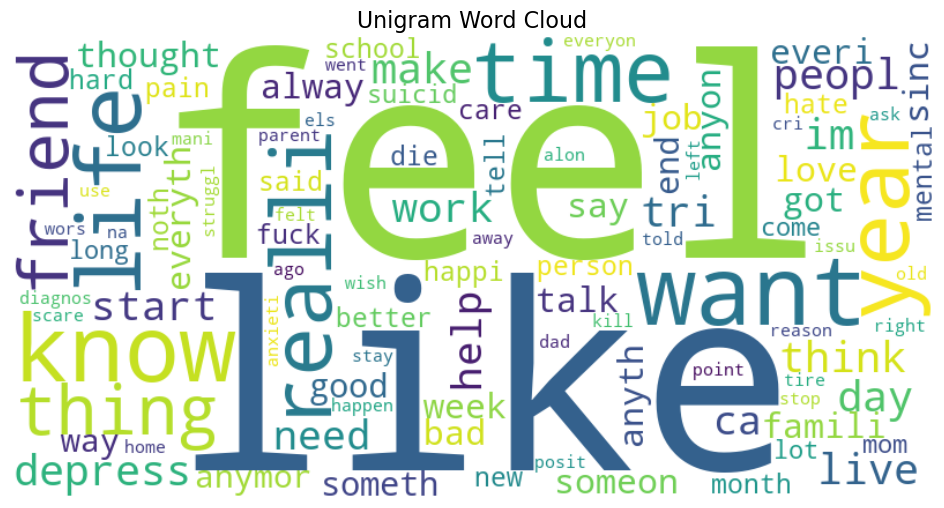

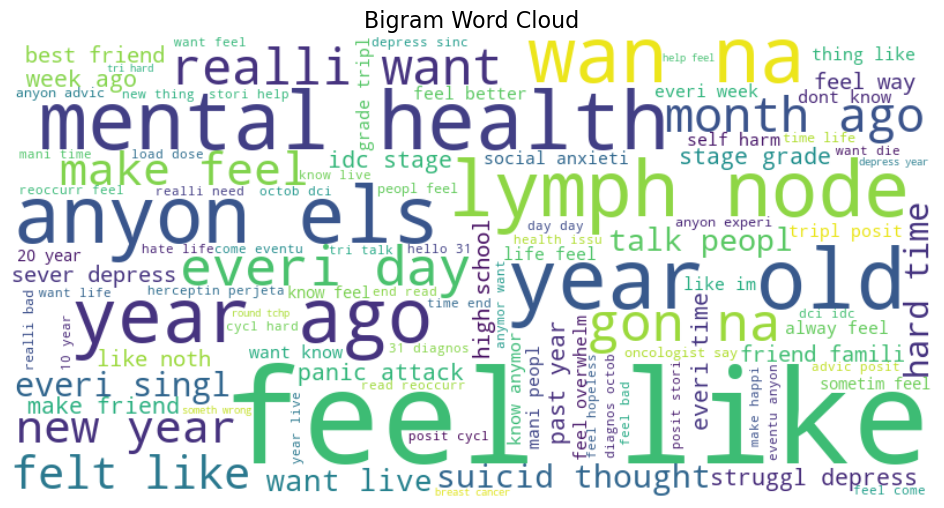

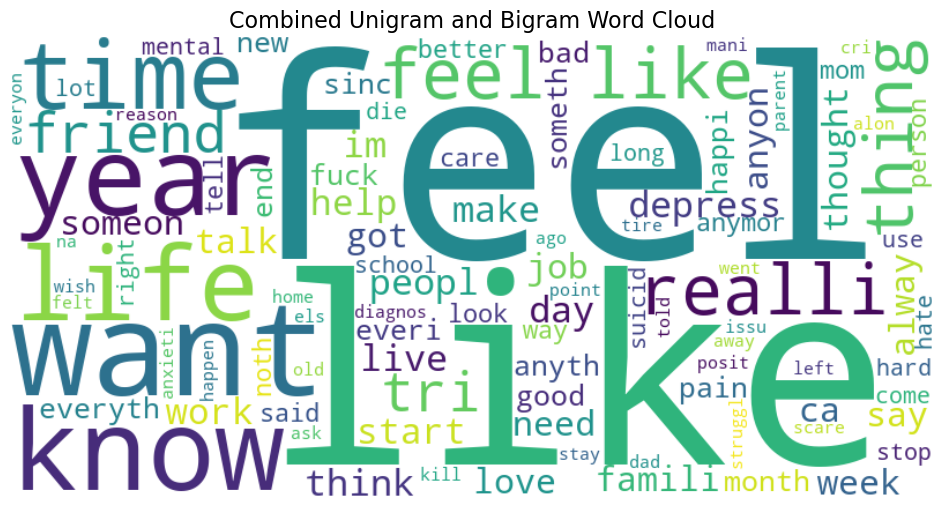

In [5]:
# Initialize, extract, save, analyze, train and generate word clouds.
# Initialize the n-gram extractor
ngram_extractor = NGramFeatureExtractor(documents, labels)

# Extract features
ngram_extractor.extract_features()

# Save features
ngram_extractor.save_features()

# Analyze top features
print("\nTop Unigram Features:")
ngram_extractor.get_top_features(feature_type="unigram", top_n=10)
print("\nTop Bigram Features:")
ngram_extractor.get_top_features(feature_type="bigram", top_n=10)


# Train a model
print("\nTraining a model with unigram features...")
classifier = ngram_extractor.train_model(feature_type="unigram")

# Generate word clouds
print("\nGenerating Word Clouds...")
ngram_extractor.visualize_wordcloud(feature_type="unigram", title="Depression Word Cloud")
ngram_extractor.visualize_wordcloud(feature_type="bigram", title="Non-Depression Word Cloud")
ngram_extractor.visualize_wordcloud(feature_type="combined", title="Combined Word Cloud")

### Extract TF-IDF features, train a logistic regression model with hyperparameter tuning, and identify key features for each category.

In [49]:

# Debugging: Check documents and labels
print(f"Number of valid documents: {len(documents)}")
if documents:
    print(f"Sample document (label {labels[0]}): {documents[0]}")

# Initialize TfidfVectorizer with unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L1 is not supported by LogisticRegression with liblinear solver
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=500), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Train the best Logistic Regression model
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # No need to call .toarray() since coef_ is already a numpy array

# Get top 10 positive and negative features
top_positive_indices = np.argsort(coefficients)[-10:]  # Largest coefficients
top_negative_indices = np.argsort(coefficients)[:10]   # Smallest coefficients

print("\nTop 10 Positive Features (indicating depression):")
for i in reversed(top_positive_indices):
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

print("\nTop 10 Negative Features (indicating breast cancer):")
for i in top_negative_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")





def visualize_features(feature_names, coefficients, title, top_n=10):
    sorted_indices = np.argsort(coefficients)
    top_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[-top_n:]]
    bottom_features = [(feature_names[i], coefficients[i]) for i in sorted_indices[:top_n]]
    
    top_features.reverse()  # Largest first
    bottom_features.reverse()  # Smallest first
    
    # Plot positive features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in top_features], [f[1] for f in top_features], color='blue')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Positive Class)")
    plt.show()
    
    # Plot negative features
    plt.figure(figsize=(10, 6))
    plt.barh([f[0] for f in bottom_features], [f[1] for f in bottom_features], color='red')
    plt.xlabel("Coefficient Value")
    plt.title(f"Top {top_n} {title} Features (Negative Class)")
    plt.show()

visualize_features(feature_names, coefficients, "Depression vs Breast Cancer", top_n=10)

Number of valid documents: 293
Sample document (label 1): well quit sure begin text realiti unsur anyth brazilian matter reader feel though die insid noth make sens anymor peopl claim highli intellig liar impostor syndrom might make assert seem bias noth foolish young individu gradual destroy metaphys mental navig life faith anyth incap forc use cheer altruist child often refer angel howev seri event cast abyss bottom pit discov trapdoor lead endlessli deep fall devoid prospect return tri good even know good mean truli exist unattract overweight frequent plagu allergi give perpetu sickli appear amount fit train ever succeed boost tri thing shatter refus numb cultur opiat modern though often think life within plato cave might prefer life devoid thought seem sweeter yet stop think sinc grandmoth pass 2022 everyth unravel unsur whether life lost purpos mean signific simpli thing made joy someon love care know continu live neither wish die find place social believ unpleas other claim oppos

# Empath Extraction

In [14]:
# Categories to focus on based on the origin paper. 
# The categories are divided into linguistic features, psychological processes, personal concerns, and time orientations.
# Since we cannot use the LIWC tool, we will use the Empath tool and define similar categorical features. 

selected_categories = {
    "linguistic_features": [
        "articles", "auxiliary_verbs", "adverbs", "conjunctions", 
        "personal_pronouns", "impersonal_pronouns", "negations", 
        "prepositions", "verbs", "nouns", "adjectives", 
        "comparatives", "superlatives", "modifiers", "function_words", 
        "filler_words", "verb_tense", "slang", "jargon", 
        "formal_language", "casual_language", "exclamations", 
        "contractions", "word_complexity", "sentiment_words"
    ],
        "psychological_processes": {
        "affective": [
            "positive_emotion", "negative_emotion", "joy", "anger", 
            "sadness", "anxiety", "fear", "disgust", "love", 
            "hope", "trust", "excitement", "anticipation", 
            "relief", "sympathy", "gratitude", "shame", 
            "guilt", "envy", "pride", "contentment", "confusion",
            "boredom", "embarrassment", "longing", "nostalgia", 
            "embarrassment", "frustration", "surprise", "melancholy"
        ],
        "biological": [
            "body", "health", "illness", "pain", "hygiene", 
            "fitness", "exercise", "nutrition", "ingestion", 
            "physical_state", "medicine", "sleep", "sexual", 
            "aging", "disease", "injury", "hospital", "recovery", 
            "dieting", "mental_health", "drug_use", "headache", 
            "fatigue", "hormones", "appetite"
        ],
        "social": [
            "family", "friends", "relationships", "group_behavior", 
            "teamwork", "social_media", "communication", "community", 
            "peer_pressure", "leadership", "parenting", "mentorship", 
            "marriage", "divorce", "gender_roles", "social_identity", 
            "cultural_rituals", "networking", "altruism", "conflict", 
            "social_support", "dominance", "affiliation", "intimacy", 
            "supportiveness", "competition", "conflict_resolution", 
            "collaboration", "in-group", "out-group", "prejudice"
        ],
        "cognitive": [
            "certainty", "doubt", "insight", "cause", "discrepancy", 
            "problem_solving", "creativity", "self_reflection", "planning", 
            "memory", "perception", "attention", "reasoning", "thought_process", 
            "decision_making", "confusion", "learning", "metacognition", "adaptability", 
            "focus", "perspective", "problem_analysis", "evaluation", "interpretation",
            "logic", "intelligence", "rational_thought", "intuition", "conceptualization"
        ],
        "drives": [
            "achievement", "dominance", "affiliation", "control", 
            "self-esteem", "autonomy", "self-assertion", "power", 
            "ambition", "conformity", "subordination", "dependence", 
            "submission", "accomplishment", "independence", "order", 
            "control_seeking", "status", "prosocial_behavior"
        ],
        "spiritual": [
            "spirituality", "faith", "beliefs", "sacred", "religion", 
            "prayer", "meditation", "afterlife", "soul", "divine", 
            "god", "higher_power", "inspiration", "transcendence", 
            "morality", "ethics", "rituals", "holiness", "mindfulness"
        ]
    },
    "personal_concerns": [
        "work", "money", "wealth", "shopping", "career", "travel", 
        "home", "school", "education", "violence", "death", 
        "retirement", "spirituality", "family_life", "hobbies", 
        "volunteering", "pets", "entertainment", "parenting", 
        "sports", "adventure", "politics", "environment", 
        "safety", "technology", "materialism", "status", 
        "self_improvement", "learning", "self_growth", "happiness", 
        "life_purpose", "work_life_balance", "stress", "coping", 
        "job_satisfaction", "ambition", "legacy", "job_search", 
        "unemployment", "retirement_plans", "mental_health", "dating", 
        "romantic_relationships", "divorce", "life_stressors", "transitions"
    ],
    "time_orientations": [
        "present", "past", "future", "morning", 
        "afternoon", "evening", "day", "night", 
        "weekdays", "weekends", "seasons", "holidays", 
        "lifespan", "long_term", "short_term", 
        "routine", "historical", "epoch", "momentary", 
        "timeliness", "timelessness", "urgency", 
        "progression", "nostalgia", "anticipation"
    ]
}

In [15]:

# Initialize Empath Feature Extractor
empath_extractor = EmpathFeatureExtractor(documents, labels, selected_categories)

# Extract features
empath_extractor.extract_empath_features()

# Analyze correlations
empath_extractor.analyze_correlation()

# Filter significant results
empath_extractor.filter_significant_results()

# Map features to categories
formatted_results = empath_extractor.map_features_to_categories()
print(formatted_results)

# Save features and results
empath_extractor.save_features_and_results()

Extracted Empath features with shape: (293, 237)
Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce', 'gender_roles', 'social_identity', 'cultural_

OSError: Cannot save file into a non-existent directory: 'data/feature_extracted_data/data/feature_extracted_data'

In [8]:
# LDA Feature Extraction
lda_extractor = LDAFeatureExtractor(documents, labels, num_topics=10, passes=10)
processed_docs = lda_extractor.preprocess_documents()
lda_model, dictionary, corpus = lda_extractor.train_lda(processed_docs)
topic_distributions = lda_extractor.extract_topic_distributions(lda_model, corpus)
lda_extractor.save_features(topic_distributions, "lda_topic_distributions_with_labels.csv")

File already exists at data/feature_extracted_data/lda_topic_distributions_with_labels.csv.


## Empath Feature Extraction

In [25]:
# Installing modules, packages and dependencies

import pandas as pd
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
%pip install empath
from empath import Empath

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Initialising the Empath model

lexicon = Empath()

In [27]:
# Categories to focus on based on the origin paper. 
# The categories are divided into linguistic features, psychological processes, personal concerns, and time orientations.
# Since we cannot use the LIWC tool, we will use the Empath tool and define similar categorical features. 

selected_categories = {
    "linguistic_features": [
        "articles", "auxiliary_verbs", "adverbs", "conjunctions", 
        "personal_pronouns", "impersonal_pronouns", "negations", 
        "prepositions", "verbs", "nouns", "adjectives", 
        "comparatives", "superlatives", "modifiers", "function_words", 
        "filler_words", "verb_tense", "slang", "jargon", 
        "formal_language", "casual_language", "exclamations", 
        "contractions", "word_complexity", "sentiment_words"
    ],
        "psychological_processes": {
        "affective": [
            "positive_emotion", "negative_emotion", "joy", "anger", 
            "sadness", "anxiety", "fear", "disgust", "love", 
            "hope", "trust", "excitement", "anticipation", 
            "relief", "sympathy", "gratitude", "shame", 
            "guilt", "envy", "pride", "contentment", "confusion",
            "boredom", "embarrassment", "longing", "nostalgia", 
            "embarrassment", "frustration", "surprise", "melancholy"
        ],
        "biological": [
            "body", "health", "illness", "pain", "hygiene", 
            "fitness", "exercise", "nutrition", "ingestion", 
            "physical_state", "medicine", "sleep", "sexual", 
            "aging", "disease", "injury", "hospital", "recovery", 
            "dieting", "mental_health", "drug_use", "headache", 
            "fatigue", "hormones", "appetite"
        ],
        "social": [
            "family", "friends", "relationships", "group_behavior", 
            "teamwork", "social_media", "communication", "community", 
            "peer_pressure", "leadership", "parenting", "mentorship", 
            "marriage", "divorce", "gender_roles", "social_identity", 
            "cultural_rituals", "networking", "altruism", "conflict", 
            "social_support", "dominance", "affiliation", "intimacy", 
            "supportiveness", "competition", "conflict_resolution", 
            "collaboration", "in-group", "out-group", "prejudice"
        ],
        "cognitive": [
            "certainty", "doubt", "insight", "cause", "discrepancy", 
            "problem_solving", "creativity", "self_reflection", "planning", 
            "memory", "perception", "attention", "reasoning", "thought_process", 
            "decision_making", "confusion", "learning", "metacognition", "adaptability", 
            "focus", "perspective", "problem_analysis", "evaluation", "interpretation",
            "logic", "intelligence", "rational_thought", "intuition", "conceptualization"
        ],
        "drives": [
            "achievement", "dominance", "affiliation", "control", 
            "self-esteem", "autonomy", "self-assertion", "power", 
            "ambition", "conformity", "subordination", "dependence", 
            "submission", "accomplishment", "independence", "order", 
            "control_seeking", "status", "prosocial_behavior"
        ],
        "spiritual": [
            "spirituality", "faith", "beliefs", "sacred", "religion", 
            "prayer", "meditation", "afterlife", "soul", "divine", 
            "god", "higher_power", "inspiration", "transcendence", 
            "morality", "ethics", "rituals", "holiness", "mindfulness"
        ]
    },
    "personal_concerns": [
        "work", "money", "wealth", "shopping", "career", "travel", 
        "home", "school", "education", "violence", "death", 
        "retirement", "spirituality", "family_life", "hobbies", 
        "volunteering", "pets", "entertainment", "parenting", 
        "sports", "adventure", "politics", "environment", 
        "safety", "technology", "materialism", "status", 
        "self_improvement", "learning", "self_growth", "happiness", 
        "life_purpose", "work_life_balance", "stress", "coping", 
        "job_satisfaction", "ambition", "legacy", "job_search", 
        "unemployment", "retirement_plans", "mental_health", "dating", 
        "romantic_relationships", "divorce", "life_stressors", "transitions"
    ],
    "time_orientations": [
        "present", "past", "future", "morning", 
        "afternoon", "evening", "day", "night", 
        "weekdays", "weekends", "seasons", "holidays", 
        "lifespan", "long_term", "short_term", 
        "routine", "historical", "epoch", "momentary", 
        "timeliness", "timelessness", "urgency", 
        "progression", "nostalgia", "anticipation"
    ]
}

In [28]:
# Extracting features

def extract_empath_features(documents, lexicon, selected_categories):
    """
    Extracts Empath features from a list of documents based on selected categories.
    Parameters:
    documents (list of str): A list of documents to analyze.
    lexicon (Empath): An instance of the Empath lexicon for analyzing text.
    selected_categories (dict): A dictionary specifying the categories to extract. 
        It should have the following structure:
        {
            "linguistic_features": list of str,
            "psychological_processes": dict of {subcategory: list of str},
            "personal_concerns": list of str,
            "time_orientations": list of str
        }
    Returns:
    list of dict: A list of dictionaries where each dictionary contains the extracted features for a document.
    """

    features = []
    for doc in documents:
        doc_features = {}
        
        # Linguistic features
        for category in selected_categories["linguistic_features"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Psychological processes
        for subcategory, categories in selected_categories["psychological_processes"].items():
            for category in categories:
                doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Personal concerns
        for category in selected_categories["personal_concerns"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        # Time orientations
        for category in selected_categories["time_orientations"]:
            doc_features[category] = lexicon.analyze(doc, categories=[category])[category]
        
        features.append(doc_features)
    return features


In [29]:
# Extracting features for each document

empath_features = extract_empath_features(documents, lexicon, selected_categories)


In [30]:
# Convert features into a DataFrame
df_features = pd.DataFrame(empath_features)

# Remove constant columns
constant_columns = df_features.columns[df_features.nunique() == 1]
df_features = df_features.drop(columns=constant_columns)
print(f"Removed constant columns: {constant_columns.tolist()}")

# Validate labels
if len(set(labels)) == 1:
    raise ValueError("Labels array is constant; cannot compute correlation.")

# Calculate correlation and p-values for each feature
correlations = []
p_values = []

for column in df_features.columns:
    try:
        # Calculate Pearson correlation and p-value
        correlation, p_value = pearsonr(df_features[column], labels)
        correlations.append(correlation)
        p_values.append(p_value)
    except ValueError as e:  # Handle constant features
        print(f"Skipping feature {column} due to constant input.")
        correlations.append(None)
        p_values.append(None)

# Apply Benjamini-Hochberg correction
correction_results = multipletests(p_values, alpha=0.05, method="fdr_bh")
_, corrected_p_values, _, _ = correction_results

# Create a results DataFrame
correlation_results = pd.DataFrame({
    "Feature": df_features.columns,
    "Correlation": correlations,
    "P-Value": p_values,
    "Corrected P-Value": corrected_p_values
})

# Sort by the highest correlation (absolute value)
correlation_results = correlation_results.sort_values(by="Correlation", key=abs, ascending=False)

Removed constant columns: ['articles', 'auxiliary_verbs', 'adverbs', 'conjunctions', 'personal_pronouns', 'impersonal_pronouns', 'negations', 'prepositions', 'verbs', 'nouns', 'adjectives', 'comparatives', 'superlatives', 'modifiers', 'function_words', 'filler_words', 'verb_tense', 'slang', 'jargon', 'formal_language', 'casual_language', 'exclamations', 'contractions', 'word_complexity', 'sentiment_words', 'anxiety', 'hope', 'excitement', 'relief', 'gratitude', 'guilt', 'boredom', 'embarrassment', 'longing', 'nostalgia', 'frustration', 'melancholy', 'illness', 'fitness', 'nutrition', 'ingestion', 'physical_state', 'medicine', 'aging', 'disease', 'hospital', 'recovery', 'dieting', 'mental_health', 'drug_use', 'headache', 'fatigue', 'hormones', 'appetite', 'relationships', 'group_behavior', 'teamwork', 'community', 'peer_pressure', 'leadership', 'parenting', 'mentorship', 'marriage', 'divorce', 'gender_roles', 'social_identity', 'cultural_rituals', 'networking', 'altruism', 'conflict', '

### Outcome: 47 topics using Empath was appropriate instead of the 67 which the original paper found with LIWC 

### Saving the output of the EFE for classification modelling

In [32]:
# Saving the output of the Empath feature extraction
# Define output folder and file path
output_folder = "data/feature_extracted_data"
os.makedirs(output_folder, exist_ok=True)
correlation_results_file = os.path.join(output_folder, "empath_correlation_results.csv")

# Save the correlation results
correlation_results.to_csv(correlation_results_file, index=False)
print(f"Saved correlation results to {correlation_results_file}.")

# Add labels to the feature DataFrame
df_features["label"] = labels

# Save the features and labels
features_with_labels_file = os.path.join(output_folder, "empath_features_with_labels.csv")
df_features.to_csv(features_with_labels_file, index=False)
print(f"Saved features with labels to {features_with_labels_file}.")

Saved correlation results to data/feature_extracted_data/empath_correlation_results.csv.
Saved features with labels to data/feature_extracted_data/empath_features_with_labels.csv.


## (For Table) Highest correlation results achieved with Empath features

In [140]:
# Create the initial DataFrame with features, correlations, and p-values
result_df = pd.DataFrame({
    "Feature": df_features.columns,
    "Correlation": correlations,
    "P-Value": corrected_p_values
})

# Add significance stars based on P-Value
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    return ''  # No significance

result_df['Significance'] = result_df['P-Value'].apply(significance_stars)

# Filter significant results
significant_results = result_df[result_df['Significance'] != '']

# Map features to their respective categories
def map_features_to_categories(features, selected_categories):
    grouped_results = {}
    for feature in features:
        for category, subcategories in selected_categories.items():
            if isinstance(subcategories, list):  # Flat category
                if feature in subcategories:
                    grouped_results.setdefault(category, []).append(feature)
            elif isinstance(subcategories, dict):  # Nested subcategories
                for subcategory, sub_features in subcategories.items():
                    if feature in sub_features:
                        grouped_results.setdefault(f"{category} - {subcategory}", []).append(feature)
    return grouped_results

# Map features to categories
grouped_results = map_features_to_categories(significant_results['Feature'], selected_categories)

# Format results into a new DataFrame
formatted_results = [
    {
        "Category": category,
        "Feature": feature,
        "Correlation": significant_results.loc[significant_results['Feature'] == feature, 'Correlation'].values[0],
        "P-Value": significant_results.loc[significant_results['Feature'] == feature, 'P-Value'].values[0],
        "Significance": significant_results.loc[significant_results['Feature'] == feature, 'Significance'].values[0],
    }
    for category, features in grouped_results.items()
    for feature in features
]

# Create the final formatted DataFrame
table_df = pd.DataFrame(formatted_results).sort_values(by=["Category", "Correlation"], ascending=[True, False])

# Add a combined "Correlation (P-Value)" column for display
table_df['Correlation (P-Value)'] = table_df.apply(
    lambda row: f"{row['Correlation']:.2f} ({row['Significance']})", axis=1
)

# Select relevant columns for display
final_table = table_df[['Category', 'Feature', 'Correlation (P-Value)']]

# Display the final table
print(final_table.to_string(index=False))


                            Category          Feature Correlation (P-Value)
                   personal_concerns         violence            0.32 (***)
                   personal_concerns            death            0.27 (***)
                   personal_concerns             work            0.21 (***)
                   personal_concerns         shopping              0.16 (*)
                   personal_concerns             home              0.15 (*)
                   personal_concerns           sports              0.15 (*)
 psychological_processes - affective      contentment            0.33 (***)
 psychological_processes - affective            shame            0.30 (***)
 psychological_processes - affective             love            0.29 (***)
 psychological_processes - affective negative_emotion            0.28 (***)
 psychological_processes - affective positive_emotion            0.28 (***)
 psychological_processes - affective          sadness            0.25 (***)
 psychologic

## Topic Modelling using LDA (Latent Dirichlet Allocation)

In [33]:
#installing modules, packages and dependencies

%pip install gensim
%pip install pyldavis 
%pip install nltk
%pip install plotly
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.manifold import TSNE


# Enable Jupyter Notebook integration
pyLDAvis.enable_notebook()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Separating the documents into depressed and non-depressed

non_depressed_docs = [doc for doc, label in zip(documents, labels) if label == 0]
depressed_docs = [doc for doc, label in zip(documents, labels) if label == 1]

In [35]:
# Training LDA models for depressed and non-depressed documents
# Download NLTK stopwords and punkt if not already done
nltk.download('stopwords')
nltk.download('punkt')
# Initialize the stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(doc):
    """Tokenize, remove stopwords, and apply stemming."""
    tokens = word_tokenize(doc.lower())  # Tokenize and lowercase the text
    filtered_tokens = [
        stemmer.stem(word) for word in tokens 
        if word.isalpha() and word not in stop_words  # Remove stopwords and non-alphabetic tokens
    ]
    return filtered_tokens

def filter_docs_by_word_count(processed_docs, min_documents):
    """Filter words that appear in more than 'min_documents' docs."""
    word_doc_count = defaultdict(int)
    for doc in processed_docs:
        unique_words = set(doc)
        for word in unique_words:
            word_doc_count[word] += 1
    
    return [
        [word for word in doc if word_doc_count[word] > min_documents] 
        for doc in processed_docs
    ]

def create_corpus_and_dictionary(filtered_docs):
    """Create a dictionary and corpus from the filtered documents."""
    dictionary = corpora.Dictionary(filtered_docs)
    corpus = [dictionary.doc2bow(doc) for doc in filtered_docs]
    return dictionary, corpus

def train_lda(corpus, dictionary, num_topics=70, passes=15):
    """Train an LDA model."""
    return LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

def process_and_train_lda(docs, min_documents=10, num_topics=70, passes=15):
    """Preprocess, filter, and train LDA on the provided documents."""
    processed_docs = [preprocess(doc) for doc in docs]  # Preprocess documents
    filtered_docs = filter_docs_by_word_count(processed_docs, min_documents)  # Filter docs by word count
    dictionary, corpus = create_corpus_and_dictionary(filtered_docs)  # Create corpus and dictionary
    lda_model = train_lda(corpus, dictionary, num_topics, passes)  # Train LDA model
    return lda_model, dictionary, corpus

# Train LDA models for depressed and non-depressed documents
lda_non_depressed, non_depressed_dictionary, non_depressed_corpus = process_and_train_lda(non_depressed_docs)
lda_depressed, depressed_dictionary, depressed_corpus = process_and_train_lda(depressed_docs)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataszasiwinska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
# Visualizing for non-depressed topics

NUM_TOPICS = 30  # Reduce to a manageable number

# Modify the process_and_train_lda function to use the adjusted number of topics
lda_non_depressed, non_depressed_dictionary, non_depressed_corpus = process_and_train_lda(
    non_depressed_docs, min_documents=10, num_topics=NUM_TOPICS, passes=15
)

lda_depressed, depressed_dictionary, depressed_corpus = process_and_train_lda(
    depressed_docs, min_documents=10, num_topics=NUM_TOPICS, passes=15
)

def visualize_lda(lda_model, corpus, dictionary):
    """Visualize the LDA model directly in the notebook."""
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    return vis  # Return the visualization object

# Visualize for non-depressed topics
print("Visualizing Non-Depressed Topics:")
visualize_lda(lda_non_depressed, non_depressed_corpus, non_depressed_dictionary)

Visualizing Non-Depressed Topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.064211 -0.102988       1        1  12.408262
24    -0.195892  0.074054       2        1   8.029107
13    -0.100210  0.012352       3        1   7.335215
27     0.117000 -0.042493       4        1   5.831763
3      0.182264  0.111275       5        1   4.340547
16     0.103313 -0.070418       6        1   4.207674
1     -0.148896  0.142026       7        1   4.074961
20    -0.142269  0.123293       8        1   4.022150
26     0.018279  0.011933       9        1   3.982617
14     0.077094  0.149762      10        1   3.762763
19     0.117067 -0.052830      11        1   3.710395
9      0.074280 -0.005912      12        1   3.648135
23     0.174058  0.000948      13        1   3.430254
17    -0.094195 -0.113678      14        1   3.352600
15    -0.043403  0.096711      15        1   3.348678
7     -0.016161 -0.077689      16        1   3.202046
22    -0.105665 -0.123366      17        1   2.957027
0     -0.141972 -0.108870      18        1   2.919262
8      0.044719  0.031507      19        1   2.138596
18    -0.057720 -0.055160      20        1   2.069700
10     0.072591  0.087180      21        1   1.855714
21    -0.023244 -0.125786      22        1   1.716505
4      0.016080 -0.148107      23        1   1.713812
25     0.180562  0.147180      24        1   1.576121
2      0.148530 -0.086483      25        1   1.304337
28    -0.137893  0.090303      26        1   1.138878
11    -0.127810  0.006373      27        1   0.997467
5     -0.014924  0.019012      28        1   0.645172
12    -0.021279  0.004542      29        1   0.140121
29    -0.018515  0.005328      30        1   0.140121, topic_info=      Term       Freq      Total Category  logprob  loglift
5     feel  48.000000  48.000000  Default  30.0000  30.0000
46  breast  24.000000  24.000000  Default  29.0000  29.0000
33   start  33.000000  33.000000  Default  28.0000  28.0000
51    node  26.000000  26.000000  Default  27.0000  27.0000
14    time  26.000000  26.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
7       go   0.031557  35.362906  Topic30  -4.1355  -0.4512
17    know   0.031384  30.595250  Topic30  -4.1410  -0.3119
57    like   0.031480  41.930961  Topic30  -4.1379  -0.6240
1     back   0.031300  31.692929  Topic30  -4.1437  -0.3498
0    anyon   0.030949  32.359573  Topic30  -4.1549  -0.3819

[1117 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
15        1  0.190575  also
15        3  0.047644  also
15        5  0.142932  also
15        6  0.095288  also
15        9  0.047644  also
...     ...       ...   ...
54       16  0.031541  year
54       18  0.031541  year
54       20  0.031541  year
54       22  0.031541  year
54       24  0.094622  year

[664 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 25, 14, 28, 4, 17, 2, 21, 27, 15, 20, 10, 24, 18, 16, 8, 23, 1, 9, 19, 11, 22, 5, 26, 3, 29, 12, 6, 13, 30])

In [37]:
# Visualizing for depressed topics
print("Visualizing Depressed Topics:")
visualize_lda(lda_depressed, depressed_corpus, depressed_dictionary)

Visualizing Depressed Topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
27    -0.014709 -0.036925       1        1  19.382709
29    -0.003275  0.072192       2        1  19.211481
24     0.004114 -0.013730       3        1  19.148907
6     -0.003908  0.004016       4        1   7.870463
16     0.022817  0.010104       5        1   4.201662
5      0.025130 -0.063132       6        1   3.063898
15    -0.059402  0.000452       7        1   2.524900
1      0.030118  0.029235       8        1   2.428210
11     0.056741 -0.011613       9        1   2.406676
28    -0.023460 -0.141886      10        1   2.225606
12     0.003879 -0.064395      11        1   1.779873
21    -0.019035 -0.019947      12        1   1.755113
2     -0.009246 -0.000552      13        1   1.616937
26    -0.034555  0.005849      14        1   1.386371
20     0.033706 -0.092902      15        1   1.364738
18     0.040907 -0.055893      16        1   1.322979
14    -0.060955 -0.108642      17        1   1.270215
23    -0.154983  0.117301      18        1   1.242587
25     0.026863 -0.028971      19        1   0.932096
0     -0.042507 -0.076102      20        1   0.904964
7     -0.229808  0.084371      21        1   0.818566
22     0.006715 -0.058888      22        1   0.675460
13     0.054578 -0.027260      23        1   0.574660
4      0.103221 -0.045668      24        1   0.495393
8      0.174226  0.127132      25        1   0.473817
3      0.060641  0.164593      26        1   0.397510
17    -0.111392  0.022878      27        1   0.358763
10     0.034429  0.069082      28        1   0.110733
19     0.044648  0.069310      29        1   0.027357
9      0.044502  0.069991      30        1   0.027357, topic_info=       Term        Freq       Total Category  logprob  loglift
14     feel  659.000000  659.000000  Default  30.0000  30.0000
104    like  601.000000  601.000000  Default  29.0000  29.0000
158   would  318.000000  318.000000  Default  28.0000  28.0000
130    want  405.000000  405.000000  Default  27.0000  27.0000
224  friend  229.000000  229.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
173    time    0.014738  309.778027  Topic30  -6.2402  -1.7492
9      even    0.014733  333.833005  Topic30  -6.2405  -1.8243
130    want    0.014694  405.010321  Topic30  -6.2432  -2.0203
303    take    0.014640  122.093570  Topic30  -6.2468  -0.8248
92    first    0.014616   83.409277  Topic30  -6.2485  -0.4455

[1676 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
160       1  0.160867      abl
160       2  0.060325      abl
160       4  0.382060      abl
160       5  0.080434      abl
160       9  0.060325      abl
...     ...       ...      ...
471       8  0.069725  younger
471       9  0.069725  younger
471      13  0.069725  younger
471      15  0.069725  younger
471      23  0.069725  younger

[4848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 30, 25, 7, 17, 6, 16, 2, 12, 29, 13, 22, 3, 27, 21, 19, 15, 24, 26, 1, 8, 23, 14, 5, 9, 4, 18, 11, 20, 10])

### Outcomes: 30 topics using LDA was appropriate instead of the 70 which the original paper found 

In [38]:
# Extract topic distributions for non-depressed documents
non_depressed_topic_distributions = [
    dict(lda_non_depressed.get_document_topics(doc, minimum_probability=0))
    for doc in non_depressed_corpus
]

# Extract topic distributions for depressed documents
depressed_topic_distributions = [
    dict(lda_depressed.get_document_topics(doc, minimum_probability=0))
    for doc in depressed_corpus
]

# Convert to matrices (rows=documents, columns=topics)
def topic_distribution_to_matrix(topic_distributions, num_topics):
    matrix = np.zeros((len(topic_distributions), num_topics))
    for i, distribution in enumerate(topic_distributions):
        for topic_id, prob in distribution.items():
            matrix[i, topic_id] = prob
    return matrix

non_depressed_matrix = topic_distribution_to_matrix(non_depressed_topic_distributions, NUM_TOPICS)
depressed_matrix = topic_distribution_to_matrix(depressed_topic_distributions, NUM_TOPICS)


# Combine matrices for t-SNE visualization
combined_matrix = np.vstack((non_depressed_matrix, depressed_matrix))

# Create labels: 0 for non-depressed, 1 for depressed
labels = [0] * len(non_depressed_matrix) + [1] * len(depressed_matrix)

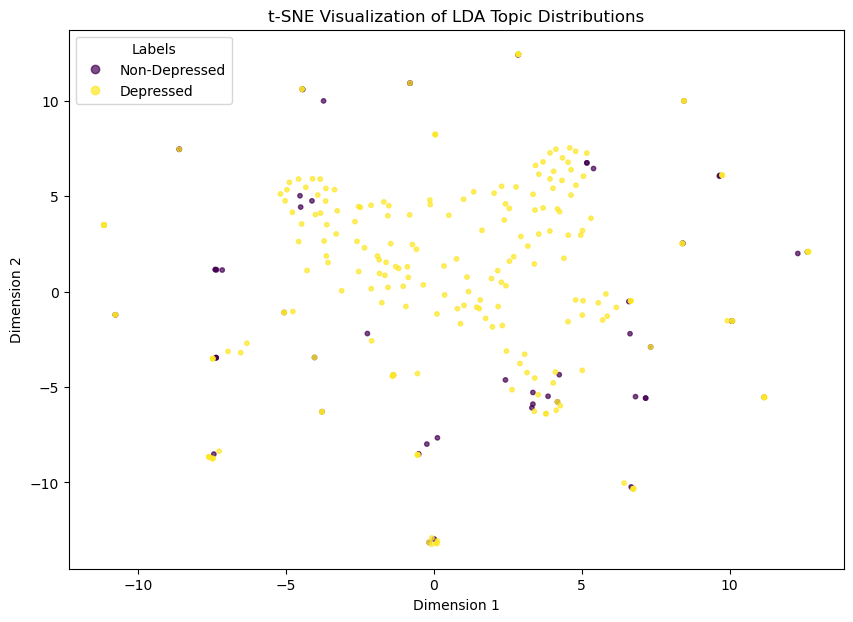

In [40]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(combined_matrix)

# Visualize the results
plt.figure(figsize=(10, 7))

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=10, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=["Non-Depressed", "Depressed"], title="Labels")
plt.title("t-SNE Visualization of LDA Topic Distributions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### Saving the output of the LDA for classification modelling

In [42]:
# Saving the LDA features and labels
# Folder for saving outputs
# Folder for saving outputs
output_folder = "data/feature_extracted_data"
os.makedirs(output_folder, exist_ok=True)

# File paths
lda_features_file = os.path.join(output_folder, "lda_topic_distributions_with_labels.csv")

# Check and save topic distributions and labels
if not os.path.exists(lda_features_file):
    # Combine topic distributions and labels into a DataFrame
    topic_distributions = np.vstack((non_depressed_matrix, depressed_matrix))
    labels_array = np.array(labels)
    lda_features_df = pd.DataFrame(topic_distributions)
    lda_features_df['label'] = labels_array  # Add labels as the last column

    # Save to CSV
    lda_features_df.to_csv(lda_features_file, index=False)
    print(f"Saved LDA topic distributions and labels to {lda_features_file}.")
else:
    print(f"LDA topic distributions file already exists at {lda_features_file}.")


LDA topic distributions file already exists at data/feature_extracted_data/lda_topic_distributions_with_labels.csv.
